<h5>Herd Behavior Index.

HBI is a quantitative metric to measure the extent at which individual asset returns deviate 
from their respective market average; when an asset moves closely in line with the market's returns, 
it is said to behave "in herd," indicating a strong correlation with market movements. 
Significant deviations from this behavior implies that the stock is moving against the "herd", 
which could be due to unique factors specific to the asset or new market dynamics.

In [17]:
#-- Modules & Packages

import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt

import python_ta as ta

from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta

In [18]:
#-- Input Assets and Market index of choice according to yahooFinance naming system.

#-- For crypto we must compare with the only benchmark index BTC-USD price
# asset = ['LTC-USD']
# benchmark = ['BTC-USD']

#-- Whereas for a stock like GOOGLE the benchmark is its market NASDAQ ^IXIC 
asset = ['GOOG']
benchmark = ['^IXIC']

In [19]:
#-- Collecting 3 years 
start_date = date.today() + relativedelta(months = - 60)
end_date = date.today()

#-- 1h ohlcv data collection
df_asset = yf.download(asset, start_date, end_date, interval = '1D')
df_benchmark = yf.download(benchmark, start_date, end_date, interval = '1D')

#-- Daily returns 
asset_ret = df_asset['Close'].pct_change().dropna()
benchmark_ret = df_benchmark['Close'].pct_change().dropna()

#-- Rolling window
window_sz =  30

#-- Rolling Herding Behavior Index
rolling_HBI = (np.abs(asset_ret - benchmark_ret).rolling(window_sz).mean() / 
               np.abs(asset_ret).rolling(window_sz).mean())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


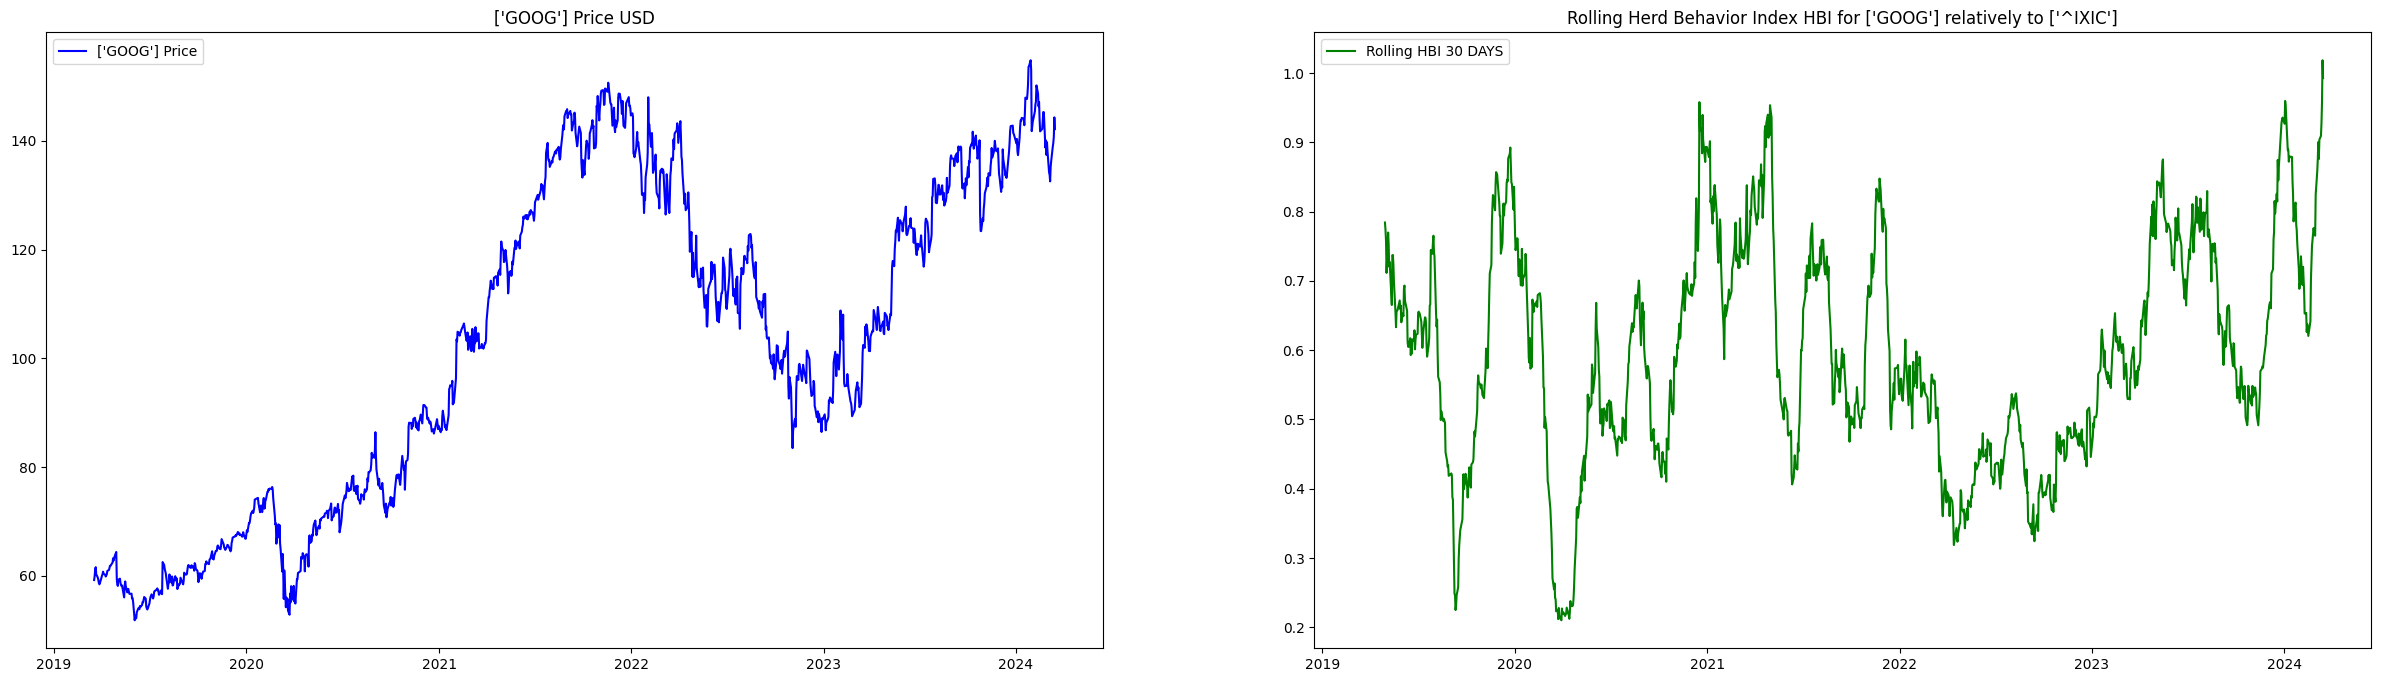

In [20]:
#-- Plotting 

fig, (ax1, ax2) = plt.subplots(1, 2 , figsize=(30,8), sharex= True)


#-- Plot of selected asset
ax1.plot(df_asset['Close'], label = f'{asset} Price', color = 'blue')
ax1.set_title(f'{asset} Price USD')
ax1.legend()

#-- Plot of index, benchmark
ax2.plot(rolling_HBI, label = f'Rolling HBI 30 DAYS', color = 'green')
ax2.set_title(f'Rolling Herd Behavior Index HBI for {asset} relatively to {benchmark}')
ax2.legend()

When comparing GOOGLE price with its Rolling Herd Behavior Index HBI, the HBI measures
how strong is the deviation between GOOG returns and the NASDAQ market average returns 
through a rolling 30 day window, lower HBI marks are indicative of returns matching the 
markets returns while higher HBI suggest herding behavior, higher HBI indicate less 
conformity with the market dynamic and trend.

<h5>Rolling Quantile Regression

The RQR plot presents coefficient fluctuation which provide insights into an asset's sensitivity to its Market or Benchmark movements at various quantiles.

In [21]:
#-- Modules & Packages 
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt

import python_ta as ta

from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
import statsmodels.formula.api as smf 
import warnings

#-- Remove warnings
warnings.filterwarnings('ignore')

[*********************100%***********************]  2 of 2 completed

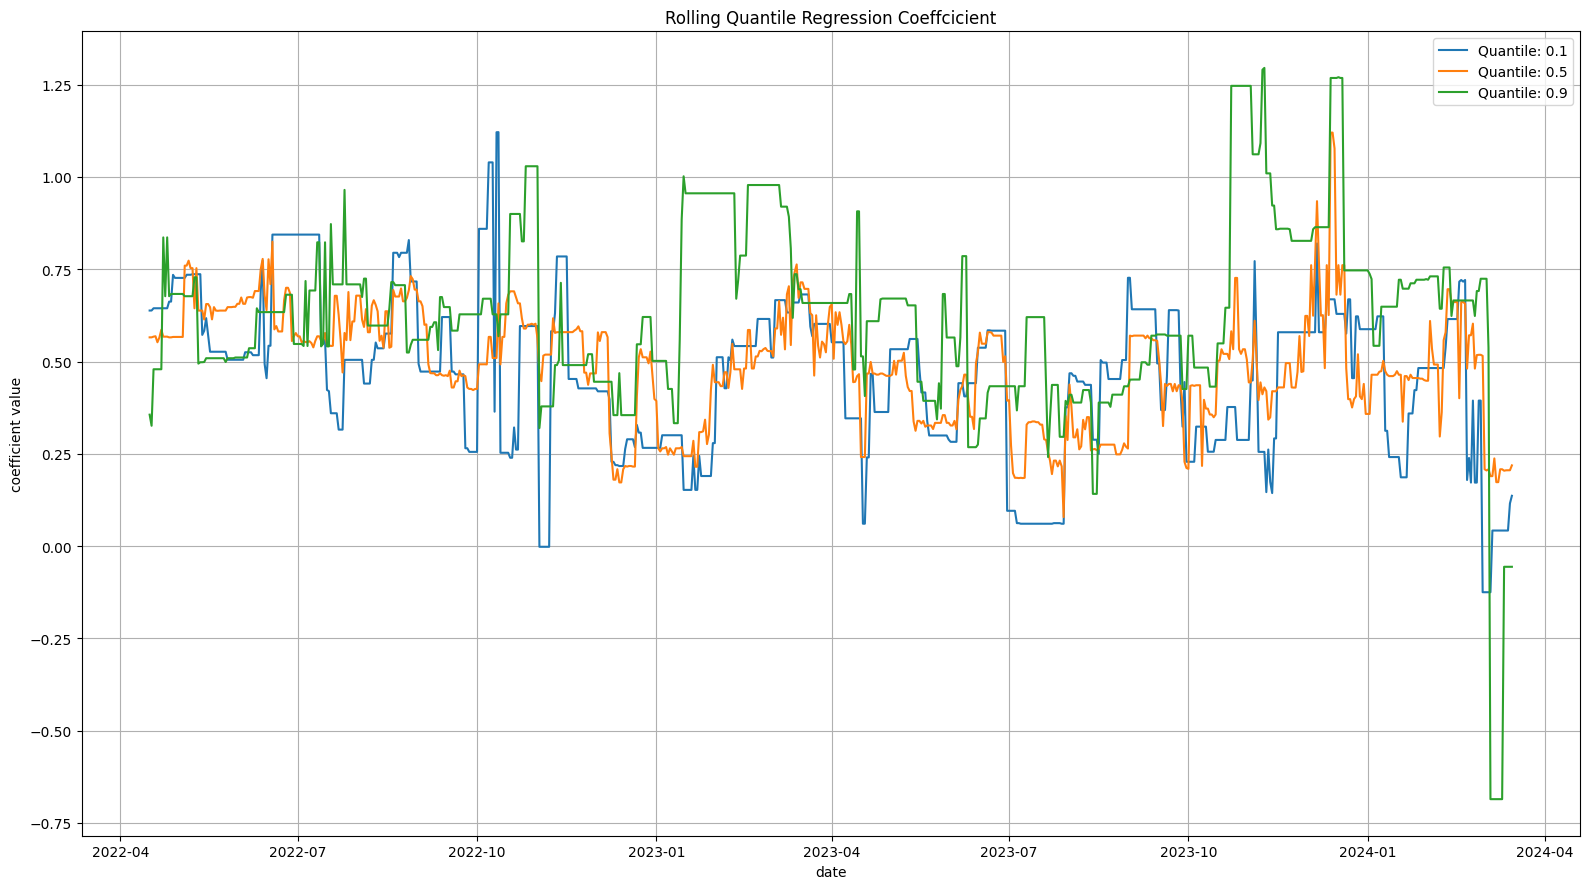

In [24]:
#-- Select asset ticker and market ticker in 
# tickers = ['GOOG', '^IXIC']

tickers = ['LTC-USD', 'BTC-USD']

#-- Collecting only Close price Data
start_date_RQR = date.today() + relativedelta(months = - 24)

df =  yf.download(tickers, start_date_RQR, end_date)['Close']

#-- Daily returns
returns = df.pct_change().dropna()

#-- Dataframe for regression 
reg_df = returns.copy()
reg_df.columns = ["Asset", "Market_idx"]

#-- Defining Rolling Window & Quantiles 

quantiles = [0.1, 0.5, 0.9]
window_sz_q = 30 #-- one year of stock market trading days

#-- Rolling Regression results 
rolling_params = {quantile: {"Intercept": [], "Market_idx": []} for quantile in quantiles}

for start in range(0, len(reg_df) - window_sz_q):
    window_data = reg_df.iloc[start : start + window_sz_q]
    for quantile in quantiles:
        mod = smf.quantreg("Asset ~ Market_idx", window_data)
        res = mod.fit(q = quantile)
        rolling_params[quantile]["Intercept"].append(res.params['Intercept'])
        rolling_params[quantile]["Market_idx"].append(res.params["Market_idx"])

rolling_index = reg_df.index[window_sz_q - 1 : -1]
rolling_dfs = {quantile: pd.DataFrame(data, index = rolling_index) for quantile, data in rolling_params.items()}

#-- Plot

plt.figure(figsize=(16,9))
for quantile in quantiles:
    plt.plot(rolling_dfs[quantile]['Market_idx'], label = f'Quantile: {quantile}')
plt.title("Rolling Quantile Regression Coeffcicient")
plt.xlabel("date")
plt.ylabel("coefficient value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<h5>How to read the plot of Rolling Quantile Regression?

<h6>

<h3>CSAD: Cross Sectional Absolute Divergence.

<h6>The CSAD calculates the absolute average deviation of each asset's relatively
to the market average return. <br>This approach offers a perspective on herding behavior by 
looking at the dispersion of returns across a portfolio of assets.

In [25]:
#-- Input tickers to make up portfolio, make sure to follow
#-- naming rules defined by yahooFinance 
tickers_portfolio = ["BTC-USD","XRP-USD","LINK-USD", 'ATOM-USD','MATIC-USD','AVAX-USD','SOL-USD',"ETH-USD","LTC-USD","XMR-USD","OMG-USD","FTM-USD","ATOM-USD"]
#-- Data collecting
data_prtfl =  yf.download(tickers_portfolio, start_date, end_date)['Close']

#-- Daily returns 
returns_prtfl = data_prtfl.pct_change().dropna()

#-- Rolling window size 
rolling_window_CSAD = 30

def CSAD_roll(asset_returns, portfolio_returns, window):
    CSAD_values = []
    for i in range(len(asset_returns) - window + 1):
        window_data = asset_returns.iloc[i:i+window]
        window_market = portfolio_returns[i:i+window].mean()
        N = len(window_data.columns)
        CSAD = (N/(N - 1)) * np.sum(np.abs(window_data.sub(window_market, axis = 0)).mean(axis=1)) 
        CSAD_values.append(CSAD)
    return pd.Series(CSAD_values, index = asset_returns.index[window - 1:]) 

#-- Rolling CSAD for 
rolling_CSAD_values = CSAD_roll(returns_prtfl[tickers[:-1]], returns_prtfl["BTC-USD"], rolling_window_CSAD)

[*********************100%***********************]  12 of 12 completed


ZeroDivisionError: division by zero